In [1]:
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import openpyxl
from openpyxl import load_workbook
import pandas as pd
import math
import seaborn as sns 
import umap
import umap.plot
from bokeh.plotting import figure, show, save, output_notebook, output_file
from bokeh.resources import INLINE 
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import RdBu3,RdBu9
from PIL import Image
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
randomstate = 42
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, PandasTools, Descriptors, Draw, PropertyMol, rdmolfiles, rdFMCS
from rdkit import RDConfig
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions, Font
DrawingOptions.bondLineWidth=1.8
DrawingOptions.includeAtomNumbers=False
size = (150, 150)
import plotly.express as px

# Load data

In [2]:
ci = pd.read_excel('example_descriptors.xlsx','descriptors',index_col=0,header=1,engine='openpyxl')
compinp = ci[ci.columns[1:-3]].loc[ci.index[:]]
compinp.index = compinp.index.astype(int)
compinp.dropna(axis=0,inplace=True)

inp2 = pd.read_excel("example_identifiers.xlsx",index_col=1,header=2,engine='openpyxl')
inp2.index = inp2.index.astype(int)

#rxndata = pd.read_excel("example_rxn_data.xlsx","reactions",header=2,index_col=2,nrows=1776,engine='openpyxl')

**Remove colinear descriptors and descriptors with all values = 0 (optional)**

If a pair of descriptors have an Pearson correlation coefficient (r) value greater than the threshold one descriptor will be removed.

In [3]:
threshold = 0.95

print('Shape of descriptors file before curation: ',compinp.shape)
#compinp = compinp.astype(float)
df_corr = compinp.corr()
df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
compinp = compinp[un_corr_idx]

compinp = compinp.loc[:, (compinp != 0).any(axis=0)]

print('Shape of descriptors file after curation: ',compinp.shape)

Shape of descriptors file before curation:  (1544, 190)
Shape of descriptors file after curation:  (1544, 139)


**Subsets from the identifiers file**
- Create sets of descriptors
- Create sets of ligand IDs (only contain IDs for ligands that have descriptors)
- Create sets of ligand names from subsets (only contain IDs for ligands that have descriptors, used in interactive plots)

If testing is required, phosphines 1431, 1432, 1433 are in the identifiers file but not in the descriptors file.

In [4]:
X_all = np.array(compinp)
X_com = np.array(compinp.loc[inp2["COM"]==1])
X_sigma = np.array(compinp.loc[inp2["sigma"]==1])
X_PC3 = np.array(compinp.loc[inp2["PC3"]==1])
X_PAr3 = np.array(compinp.loc[inp2["PAr3"]==1])
X_PN3 = np.array(compinp.loc[inp2["P[N]3"]==1])
X_PO3 = np.array(compinp.loc[inp2["P(OR)3"]==1])
X_PO2N = np.array(compinp.loc[inp2["Phosphoramidite"]==1])
X_PON2 = np.array(compinp.loc[inp2["PON2"]==1])
X_BW = np.array(compinp.loc[inp2["Buchwald 1"]==1])

X_all_ids = np.array(compinp.index)
X_com_ids = np.array(compinp.loc[inp2["COM"]==1].index)
X_sigma_ids = np.array(compinp.loc[inp2["sigma"]==1].index)
X_PC3_ids = np.array(compinp.loc[inp2["PC3"]==1].index)
X_PAr3_ids = np.array(compinp.loc[inp2["PAr3"]==1].index)
X_PN3_ids = np.array(compinp.loc[inp2["P[N]3"]==1].index)
X_PO3_ids = np.array(compinp.loc[inp2["P(OR)3"]==1].index)
X_PO2N_ids = np.array(compinp.loc[inp2["Phosphoramidite"]==1].index)
X_PON2_ids = np.array(compinp.loc[inp2["PON2"]==1].index)
X_BW_ids = np.array(compinp.loc[inp2["Buchwald 1"]==1].index)

X_all_names = np.array(inp2["ligand"].loc[X_all_ids])
X_com_names = np.array(inp2['ligand'].loc[X_com_ids])
X_sigma_names = np.array(inp2['ligand'].loc[X_sigma_ids])
X_PC3_names = np.array(inp2['ligand'].loc[X_PC3_ids])
X_PAr3_names = np.array(inp2['ligand'].loc[X_PAr3_ids])
X_PN3_names = np.array(inp2['ligand'].loc[X_PN3_ids])
X_PO3_names = np.array(inp2['ligand'].loc[X_PO3_ids])
X_PO2N_names = np.array(inp2['ligand'].loc[X_PO2N_ids])
X_PON2_names = np.array(inp2['ligand'].loc[X_PON2_ids])
X_BW_names = np.array(inp2['ligand'].loc[X_BW_ids])

**Scale the data**

In [5]:
scaler = StandardScaler()   # Calculates z-scores
scaler.fit(X_all)           # Compute the mean and std to be used for later scaling, change to appropriate set

X_all_sc    = scaler.transform(X_all)
X_com_sc    = scaler.transform(X_com)
X_sigma_sc = scaler.transform(X_sigma)
X_PC3_sc = scaler.transform(X_PC3)
X_PAr3_sc = scaler.transform(X_PAr3)
X_PN3_sc = scaler.transform(X_PN3)
X_PO3_sc = scaler.transform(X_PO3)
X_PO2N_sc = scaler.transform(X_PO2N)
X_PON2_sc = scaler.transform(X_PON2)
X_BW_sc = scaler.transform(X_BW)

**Fitting on a different subset (optional)**

In [ ]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test_sc = scaler.transform(X_test)
X_test2_sc = scaler.transform(X_test2)

# 2D score plot

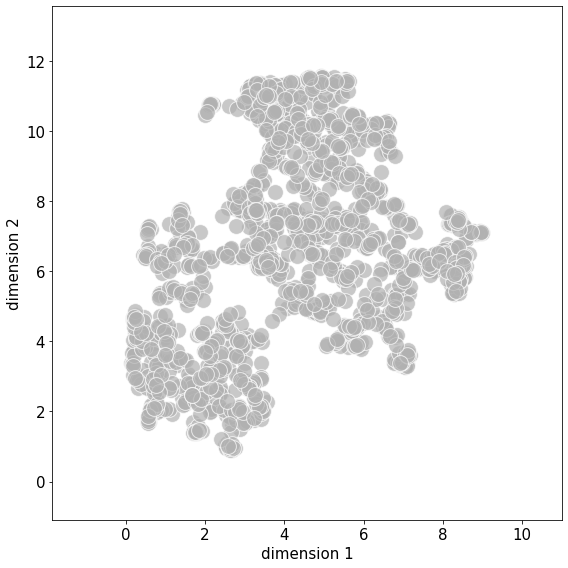

In [6]:
X_main_sc = X_all_sc
X_main_ids = X_all_ids

reducer = umap.UMAP(random_state=42)
reducer.fit(X_main_sc)
X_all_red = reducer.transform(X_main_sc)

x_min, x_max = X_all_red[:,0].min() - 2, X_all_red[:,0].max() + 2
y_min, y_max = X_all_red[:,1].min() - 2, X_all_red[:,1].max() + 2
plt.figure(figsize=(8,8))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.xlabel(f"dimension 1",fontsize=15)
plt.ylabel(f"dimension 2",fontsize=15)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.scatter(X_all_red[:,0], X_all_red[:,1],c='#B1B1B1',alpha=0.7,marker=".",s=1000,edgecolor='white')

### plotting labels for main set
#for i in range(0,len(X_all_red)):
#    plt.text(X_all_red[i,0],X_all_red[i,1]," "+str(X_main_ids[i]),color="red",fontsize=10,ha="left") 

plt.tight_layout()
#plt.show()  
#plt.savefig("umap1.png",dpi=300)

**PCA for comparison**

Variance explained by PCs: [0.26755616 0.13153824 0.10982794 0.06204438]
Total variance explained by PCs: 0.570966731055769


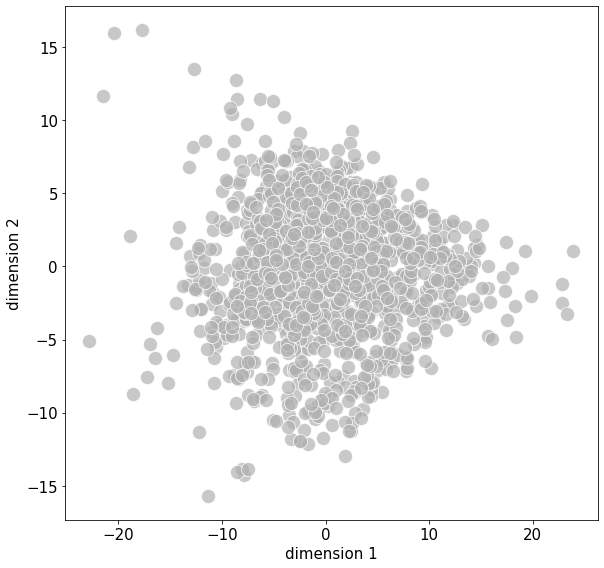

In [11]:
pca = PCA(n_components=4)
pca.fit(X_all_sc)
X_all_pca    = pca.transform(X_all_sc)
pca_score = pca.explained_variance_ratio_
pca_values = pca.singular_values_
V = pca.components_
print('Variance explained by PCs:',pca.explained_variance_ratio_)
print('Total variance explained by PCs:',np.sum(pca.explained_variance_ratio_))

x_min, x_max = X_all_red[:,0].min() - 2, X_all_red[:,0].max() + 2
y_min, y_max = X_all_red[:,1].min() - 2, X_all_red[:,1].max() + 2
plt.figure(figsize=(8.5,8))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.xlabel(f"dimension 1",fontsize=15)
plt.ylabel(f"dimension 2",fontsize=15)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)
#plt.xlim(x_min,x_max)
#plt.ylim(y_min,y_max)
plt.scatter(X_all_pca[:,0], X_all_pca[:,1],c='#B1B1B1',alpha=0.7,marker=".",s=800,edgecolor='white')

plt.tight_layout()
#plt.show()
#plt.savefig("pca.png",dpi=300)

# K-means clustering

Note that K-means is not effective at finding inherent clusters in the dataset (see HDBSCAN below). However, K-means is an appropriate method to cluster homogeneous datasets without clear inherent clusters. See https://scikit-learn.org/stable/modules/clustering.html

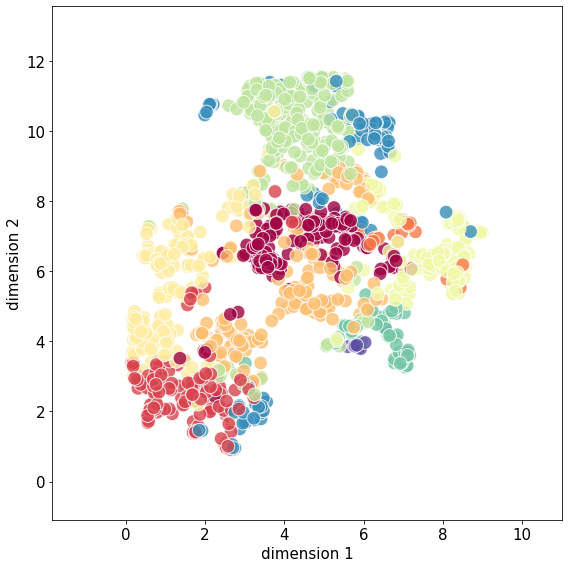

In [7]:
X_main_sc = X_all_sc
X_main_ids = X_all_ids
X_main_names = X_all_names
number_clusters = 10

standard_embedding = umap.UMAP(random_state=42).fit_transform(X_main_sc)
kmeans_labels = cluster.KMeans(n_clusters=number_clusters).fit_predict(X_main_sc)

f_ind_1 = 0
f_ind_2 = 1
x_min, x_max = standard_embedding[:,0].min() - 2, standard_embedding[:,0].max() + 2
y_min, y_max = standard_embedding[:,1].min() - 2, standard_embedding[:,1].max() + 2
plt.figure(figsize=(8,8))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.xlabel(f"dimension 1",fontsize=15)
plt.ylabel(f"dimension 2",fontsize=15)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.scatter(standard_embedding[:, 0],standard_embedding[:, 1],c=kmeans_labels,cmap='Spectral',alpha=0.8,marker=".",s=750,edgecolor='white')

plt.tight_layout()
#plt.show()  
#plt.savefig("umap_kmeans.png",dpi=300)

**Interactive K-means plot**

In [8]:
X_main_sc = X_all_sc
X_main_ids = X_all_ids
X_main_names = X_all_names
number_clusters = 10

embedding = umap.UMAP(random_state=42).fit(X_main_sc)
kmeans_labels = cluster.KMeans(n_clusters=number_clusters).fit_predict(X_main_sc)

hover_df = pd.DataFrame({'ID':X_main_ids,'Name':X_main_names,'Cluster':kmeans_labels})
int_plot = umap.plot.interactive(embedding, labels=hover_df['Cluster'], hover_data=hover_df)
show(int_plot)

# HDBSCAN clustering

HDBSCAN is an effective method for finding inherent clusters in the dataset.

https://umap-learn.readthedocs.io/en/latest/clustering.html

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

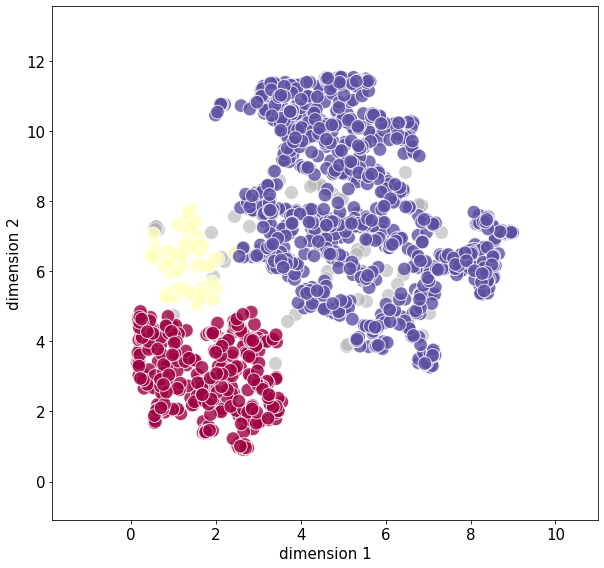

In [9]:
X_main_sc = X_all_sc
X_main_ids = X_all_ids
X_main_names = X_all_names

### standard and recommended settings
clusterable_embedding = umap.UMAP(random_state=42).fit_transform(X_main_sc)
#clusterable_embedding = umap.UMAP(n_neighbors=30,min_dist=0.0,n_components=2,random_state=42).fit_transform(X_main_sc)

labels = hdbscan.HDBSCAN(min_samples=10,min_cluster_size=50).fit_predict(clusterable_embedding)

x_min, x_max = clusterable_embedding[:,0].min() - 2, clusterable_embedding[:,0].max() + 2
y_min, y_max = clusterable_embedding[:,1].min() - 2, clusterable_embedding[:,1].max() + 2
plt.figure(figsize=(8.5,8))
extent = [x_min,x_max,y_min,y_max]
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
plt.xlabel(f"dimension 1",fontsize=15)
plt.ylabel(f"dimension 2",fontsize=15)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],clusterable_embedding[~clustered, 1],c='#B1B1B1',alpha=0.6,marker=".",s=750,edgecolor='white')
plt.scatter(clusterable_embedding[clustered, 0],clusterable_embedding[clustered, 1],c=labels[clustered],cmap='Spectral',alpha=0.8,marker=".",s=750,edgecolor='white')

plt.tight_layout()
#plt.show()  
#plt.savefig("umap_hbdscan.png",dpi=300)

# Summary of UMAP variables

In [ ]:
reducer = umap.UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.1, # default 0.1, The effective minimum distance between embedded points.
               spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=1, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )